In [1]:
text_list=[]
def create_token(tweet) :
  tweet=tweet.split()
  text_list.append(tweet)

In [2]:
import pandas as pd 
import gensim
from gensim import corpora, models
from gensim.models import Phrases


In [3]:
raw_data=pd.read_csv('cleaned_dataset.csv')

In [4]:
raw_data.tail()

,title,category,cleaned_title
91012,"Ketumpahan Air Panas di Pesawat, Kamu Bisa Tun...",travel,tumpah air panas pesawat kamu tuntut maskapai
91013,Foto: Bali & 9 Destinasi Paling Instagramable ...,travel,foto bal destinasi paling instagramable tahun
91014,Game Bikin Turis Ini Liburan ke Jepang untuk.....,travel,game bikin turis libur jepang cari yakuza
91015,"Sekeluarga Didepak dari Pesawat, Maskapai Bila...",travel,keluarga depak pesawat maskapai bilang bau badan
91016,"Kapal Raib di Segitiga Bermuda, Nyaris Seabad ...",travel,kapal raib segitiga muda nyaris abad baru ketemu


In [5]:
raw_data['cleaned_title'].apply(create_token)

0        None
1        None
2        None
3        None
4        None
         ... 
91012    None
91013    None
91014    None
91015    None
91016    None
Name: cleaned_title, Length: 91017, dtype: object

In [6]:
text_list[0]

['kemnaker', 'awas', 'tka', 'meikarta']

In [7]:
bigram = Phrases(text_list, min_count=10)
trigram = Phrases(bigram[text_list])

In [8]:
for idx in range(len(text_list)):
    for token in bigram[text_list[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            text_list[idx].append(token)
    for token in trigram[text_list[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            text_list[idx].append(token)

In [9]:
dictionary = corpora.Dictionary(text_list)
dictionary.filter_extremes(no_below=5, no_above=0.2)

In [10]:
print(dictionary)

Dictionary<15547 unique tokens: ['awas', 'kemnaker', 'meikarta', 'tka', 'bni']...>


In [11]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]

In [12]:
tfidf = models.TfidfModel(doc_term_matrix) #build TF-IDF model
corpus_tfidf = tfidf[doc_term_matrix]

In [13]:
for i in corpus_tfidf :
    print(i)
    break

[(0, 0.37411001916150094), (1, 0.5311762505868636), (2, 0.5799564475653809), (3, 0.49147126396444235)]


In [66]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array
from tqdm import tqdm

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step), desc="Topics Progress"): #range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, iterations=100, passes=10, workers=15) 
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
start=1
limit=100
step=1
model_list, coherence_values = compute_coherence_values(dictionary, corpus=corpus_tfidf,
                                                        texts=text_list, start=start, limit=limit, step=step)

Topics Progress: 100%|██████████████████████████████████████████████████████████████████| 99/99 [42:59<00:00, 26.05s/it]


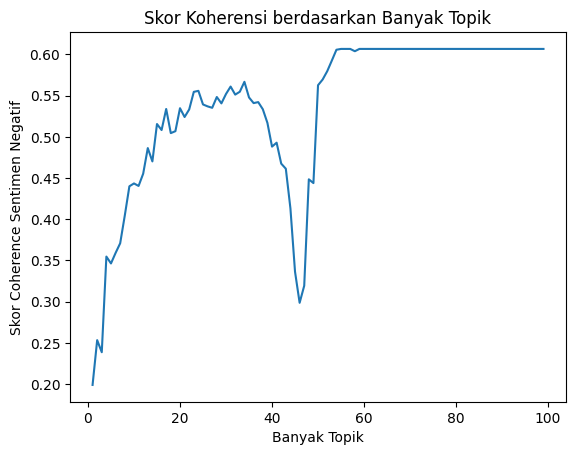

In [22]:
import matplotlib.pyplot as plt
x = range(start, limit, step)

plt.figure()
plt.plot(x, coherence_values)
plt.title('Skor Koherensi berdasarkan Banyak Topik')
plt.xlabel("Banyak Topik")
plt.ylabel("Skor Coherence Sentimen Negatif")
plt.savefig('lda-cores15-91K.jpg')
plt.show()

In [70]:
temp=0
index=0
for i in range(45):
    if coherence_values[i]>temp:
        temp=coherence_values[i]
        index=i+1
print(f'Koherensi tertinggi dicapai pada {index} topik dengan nilai {temp}')

Koherensi tertinggi dicapai pada 34 topik dengan nilai 0.566782347343523


In [71]:
coherence_values[33]

0.566782347343523

In [73]:
model_list[33].save('lda_91K_15c.model')

In [74]:
for idx, topic in model_list[33].print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.025*"kasus_positif" + 0.010*"thailand" + 0.009*"taman" + 0.007*"traveling" + 0.006*"per_hari" + 0.006*"keluar_rumah" + 0.006*"longsor" + 0.005*"hutan" + 0.005*"masa_psbb" + 0.005*"kasus"
Topic: 1 Word: 0.026*"wabah_corona" + 0.025*"imbas_corona" + 0.011*"corona" + 0.010*"tembus_rp" + 0.009*"wabah" + 0.008*"imbas" + 0.008*"orang_kaya" + 0.007*"virus_corona" + 0.007*"bicara_soal" + 0.007*"pariwisata"
Topic: 2 Word: 0.015*"anggota_dpr" + 0.013*"hand_sanitizer" + 0.010*"anggota_dprd" + 0.008*"anggota" + 0.008*"pemkot" + 0.008*"tingkat_mati" + 0.007*"meghan_markle" + 0.007*"karen_pooroe" + 0.007*"pangeran_harry" + 0.006*"jalan_rapid"
Topic: 3 Word: 0.016*"tengah_wabah" + 0.009*"walkot" + 0.008*"jakbar" + 0.007*"banjir" + 0.007*"tangerang" + 0.006*"korupsi" + 0.006*"kapolda" + 0.006*"seluruh" + 0.006*"banjir_jakarta" + 0.005*"duga_korupsi"
Topic: 4 Word: 0.073*"virus_corona" + 0.034*"new_normal" + 0.024*"virus" + 0.015*"corona" + 0.014*"minta_maaf" + 0.011*"normal" + 0.011*"